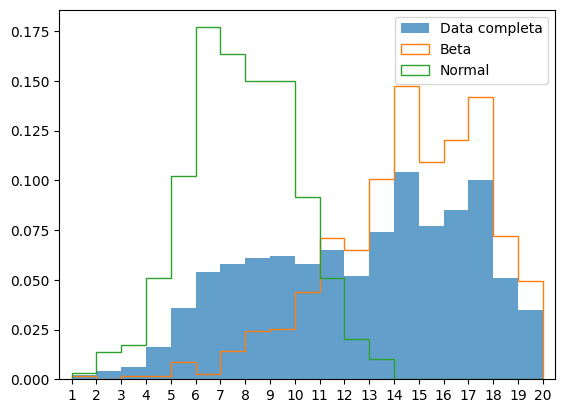

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta, norm
import stan
import nest_asyncio
nest_asyncio.apply()
import time

# Defino la función para crear datos
def create_data(alpha, beta_param, mu, sigma, p, seed, n=1000):
    np.random.seed(seed)
    out = []
    labels = []
    bernoulli = np.random.binomial(1, p, size=n)
    for i in range(len(bernoulli)):
        if bernoulli[i] == 1:
            out.append(beta.rvs(alpha, beta_param))
            labels.append('Beta')
        else:
            out.append(np.random.normal(mu, sigma))
            labels.append('Normal')
    return np.array(out), np.array(labels)

# Parámetros
alpha = 7
beta_param = 2
mu = 0.5
sigma = 0.1
p = 0.7
seed = 3

# Crear datos
data, labels = create_data(alpha, beta_param, mu, sigma, p, seed)

# Definir el número de bins que hay desde 1 a m
m = 20

# Mapear los datos al intervalo de 1 a m
data_scaled = ((data - data.min()) / (data.max() - data.min()) * (m - 1)).astype(int) + 1

plt.xticks(np.linspace(1,m,m))
plt.xlim(0.5,20.5)
plt.hist(data_scaled,bins = np.linspace(1,m,m),density=True,alpha=0.7,label='Data completa')
plt.hist(data_scaled[labels == 'Beta'], bins=np.linspace(1, m, m),histtype='step', density=True, alpha=1, label='Beta')
plt.hist(data_scaled[labels == 'Normal'], bins=np.linspace(1, m, m),histtype='step', density=True, alpha=1, label='Normal')
plt.legend()

In [2]:
min(data_scaled),max(data_scaled)

(1, 20)

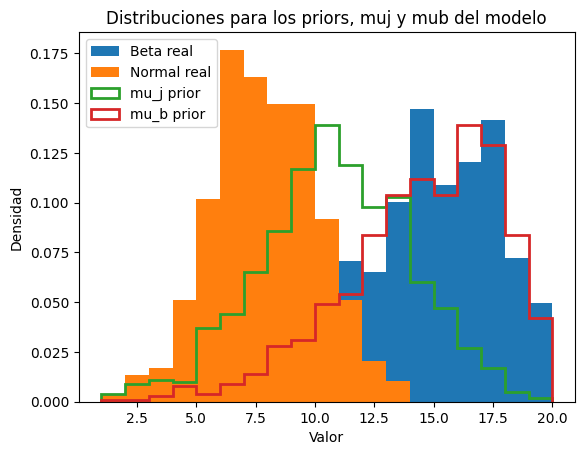

In [3]:
# Distribuciones que inicializan el algoritmo
mu_muj = 7
sigma_muj = 2

num_samples = 1000  # Número de muestras para muj_completa y mub_completa

# Generar muestras completas para muj y mub
muj_completa = np.random.normal(mu, sigma, num_samples)
mub_completa = np.random.beta(alpha, beta_param, num_samples)

# Mapear los datos al intervalo de 1 a m
muj_scaled = ((muj_completa - muj_completa.min()) / (muj_completa.max() - muj_completa.min()) * (m - 1)).astype(int) + 1
mub_scaled = ((mub_completa - mub_completa.min()) / (mub_completa.max() - mub_completa.min()) * (m - 1)).astype(int) + 1 
'''
# Crear el histograma
hist_j, bins_j, _ = plt.hist(muj_completa, bins=np.linspace(1, m,m), density=True,label='Prior j',histtype='step')
hist_b, bins_b, _ = plt.hist(mub_completa, bins=np.linspace(1, m,m), density=True,label='Prior b',histtype='step')

# Calcular las alturas de los bins. ESTO ES LO QUE VOY A USAR COMO PRIOR PARA EL MODELO.
muj = hist_j * np.diff(bins_j)  # hist es la densidad, np.diff(bins) es el ancho de cada bin
mub = hist_b * np.diff(bins_b)
'''
#plt.hist(data_scaled,bins = np.linspace(0.1,m+0.1,m),density=True,alpha=0.7,label='Data completa')
plt.hist(data_scaled[labels == 'Beta'], bins=np.linspace(1, m,m),histtype='stepfilled', density=True, alpha=1, label='Beta real')
plt.hist(data_scaled[labels == 'Normal'], bins=np.linspace(1, m,m),histtype='stepfilled', density=True, alpha=1, label='Normal real')

plt.hist(muj_scaled,density=True,lw=2,label='mu_j prior',histtype='step',bins=np.linspace(1, m,m))
plt.hist(mub_scaled,density=True,lw=2,label='mu_b prior',histtype='step',bins=np.linspace(1, m,m))


plt.xlabel('Valor')
plt.ylabel('Densidad')
plt.title('Distribuciones para los priors, muj y mub del modelo')
plt.legend()
plt.show()

In [4]:
len(muj_scaled),len(mub_scaled),len(data)

(1000, 1000, 1000)

In [5]:
my_mixture = """
data {
  int m;
  int<lower=1> K;  // data points
  array[K] int<lower=1, upper=m> datos;  // b-tagging score for jet#1
}

parameters {
  simplex[2] theta;  // Coeficiente de mezcla como simplex
  simplex[m] w_j_mode;  // Pesos de la Dirichlet
  vector<lower=0>[m-1] a_j;  // Parámetros de la Normal
  simplex[m] w_b_mode;  // Pesos de la Dirichlet
  vector<lower=0>[m-1] a_b;  // Parámetros de la Normal
}

transformed parameters {
  simplex[2] theta_ordered;  // Coeficiente de mezcla ordenado

  // Ordenar theta manualmente
  if (theta[1] < theta[2]) {
    theta_ordered[1] = theta[1];
    theta_ordered[2] = theta[2];
  } else {
    theta_ordered[1] = theta[2];
    theta_ordered[2] = theta[1];
  }

  vector[m] p0_j;  // Distribución aproximada
  vector[m-1] sign_j;  // Signos para la combinación
  vector[m] logp_j;  // Log-probabilidades

  sign_j = rep_vector(-1.0, m-1);
  p0_j = rep_vector(0.0, m);

  for (k in 1:m) {
    if (k > 1) {
      for (j in 1:(k-1)) {
        sign_j[j] = 1.0;
      }
    }
    logp_j[1] = 0.0;
    for (j in 2:m) {
      logp_j[j] = logp_j[j-1] + sign_j[j-1] * a_j[j-1];
    }
    p0_j += softmax(logp_j) * w_j_mode[k];
  }

  vector[m] p0_b;  // Distribución aproximada
  vector[m-1] sign_b;  // Signos para la combinación
  vector[m] logp_b;  // Log-probabilidades

  sign_b = rep_vector(-1.0, m-1);
  p0_b = rep_vector(0.0, m);

  for (k in 1:m) {
    if (k > 1) {
      for (j in 1:(k-1)) {
        sign_b[j] = 1.0;
      }
    }
    logp_b[1] = 0.0;
    for (j in 2:m) {
      logp_b[j] = logp_b[j-1] + sign_b[j-1] * a_b[j-1];
    }
    p0_b += softmax(logp_b) * w_b_mode[k];
  }
}

model {
  vector[2] lp;
  theta ~ dirichlet([1,1]);
  a_j ~ normal(0, 0.5);
  a_b ~ normal(0, 0.5);
  w_b_mode ~ dirichlet(rep_vector(0.05 / m, m));
  w_j_mode ~ dirichlet(rep_vector(0.05 / m, m));

  for (n in 1:K) {
    lp[1] = log(p0_j[datos[n]]);
    lp[2] = log(p0_b[datos[n]]);
    target += log_mix(theta_ordered, lp);
  }
}

generated quantities {
  array[K] int<lower=1, upper=m> replicated_data;
  for (n in 1:K) {
    real y = bernoulli_rng(theta_ordered[1]);
    if (y == 1) {
      replicated_data[n] = categorical_rng(p0_j);
    } else {
      replicated_data[n] = categorical_rng(p0_b);
    }
  }
}

"""

In [6]:
# Start the timer
start_time = time.time()


# Construyo y ajusto el modelo de la mixtura
model = stan.build(my_mixture, data= {'m': m, 'K': len(data), 'datos': data_scaled}, random_seed=33)
fit = model.sample(num_chains=5, num_samples=1000)
df = fit.to_frame()

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Time taken to run the model: {elapsed_time:.2f} seconds")

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_83s3p_a7/model_pied4oxe.stan', line 20, column 2: A
    control flow statement depends on parameter(s): theta.
Sampling:   0%
Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   0% (5/10000)
Sampling:   1% (104/10000)
Sampling:   2% (203/10000)
Sampling:   3% (303/10000)
Sampling:   4% (402/10000)
Sampling:   5% (502/10000)
Sampling:   6% (602/10000)
Sampling:   7% (701/10000)
Sampling:   8% (801/10000)
Sampling:   9% (900/10000)
Sampling:  10% (1000/10000)
Sampling:  11% (1100/10000)
Sampling:  12% (1200/10000)
Sampling:  13% (1300/10000)
Sampling:  14% (1400/10000)
Sampling:  15% (1500/10000)
Sampling:  16% (1600/10000)
Sampling:  17% (1700/10000)
Sampling:  18% (1800/10000)
Sampling:  19% (1900/10000)
Sampling:  20% (2000/10000)
Sampling:  21% (2100/10000)
Sampling:  22% (2200/10000)
Sampling:  23% (2300/10000)
Sampling:  24% (2400/10000)
Samplin

Time taken to run the model: 118.20 seconds


In [7]:
df

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,theta.1,theta.2,w_j_mode.1,...,replicated_data.991,replicated_data.992,replicated_data.993,replicated_data.994,replicated_data.995,replicated_data.996,replicated_data.997,replicated_data.998,replicated_data.999,replicated_data.1000
draws,,,,,,,,,,,,,,,,,,,,,
0,-2853.054980,0.904752,0.013077,3.0,14.0,1.0,2885.221478,0.581705,0.418295,1.705932e-120,...,7.0,15.0,9.0,5.0,17.0,12.0,7.0,12.0,14.0,10.0
1,-2860.990783,0.993968,0.001498,8.0,269.0,1.0,2906.627971,0.740092,0.259908,3.978749e-30,...,8.0,17.0,18.0,17.0,18.0,8.0,11.0,9.0,16.0,10.0
2,-2858.532583,0.977006,0.001508,9.0,849.0,1.0,2901.473533,0.648663,0.351337,3.431208e-132,...,6.0,15.0,8.0,16.0,9.0,16.0,14.0,8.0,11.0,15.0
3,-2859.897968,0.940916,0.015678,4.0,17.0,1.0,2892.102431,0.373165,0.626835,1.363112e-141,...,2.0,16.0,8.0,3.0,16.0,9.0,16.0,13.0,14.0,4.0
4,-2854.699990,0.688161,0.025043,2.0,4.0,1.0,2898.054976,0.990204,0.009796,4.599194e-11,...,5.0,11.0,16.0,18.0,13.0,13.0,13.0,6.0,17.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-2858.554511,0.966413,0.013077,5.0,44.0,1.0,2903.511849,0.539256,0.460744,1.069064e-128,...,8.0,15.0,14.0,16.0,5.0,11.0,9.0,17.0,17.0,11.0
4996,-2877.967250,0.929635,0.001498,5.0,60.0,1.0,2903.836385,0.318660,0.681340,7.256714e-176,...,17.0,17.0,10.0,14.0,12.0,17.0,7.0,8.0,7.0,6.0
4997,-2865.832291,0.962836,0.001508,6.0,95.0,1.0,2916.868255,0.578281,0.421719,2.104281e-82,...,4.0,14.0,16.0,9.0,14.0,9.0,5.0,15.0,6.0,17.0


In [8]:
df.columns

Index(['lp__', 'accept_stat__', 'stepsize__', 'treedepth__', 'n_leapfrog__',
       'divergent__', 'energy__', 'theta.1', 'theta.2', 'w_j_mode.1',
       ...
       'replicated_data.991', 'replicated_data.992', 'replicated_data.993',
       'replicated_data.994', 'replicated_data.995', 'replicated_data.996',
       'replicated_data.997', 'replicated_data.998', 'replicated_data.999',
       'replicated_data.1000'],
      dtype='object', name='parameters', length=1207)

p = 0.5959 +- 0.2056


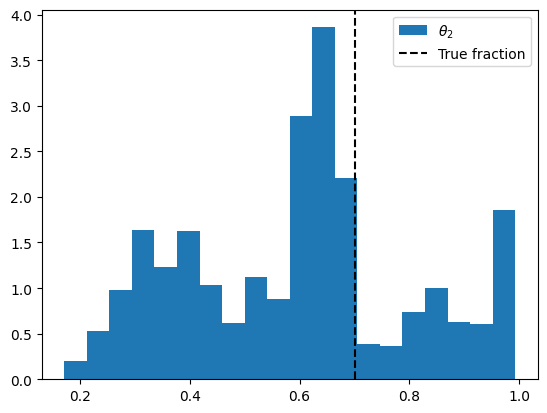

In [9]:
plt.hist(df['theta.1'],bins=20,label=r'$\theta_2$',density=True)
#plt.hist(df['theta.2'],bins=30,label=r'$\theta_1$', density = True)
plt.axvline(p,ls='--',color='black',label='True fraction')
plt.legend()
print('p =',round(np.mean(df['theta.1']),4),'+-',round(np.std(df['theta.1']),4))
plt.show()


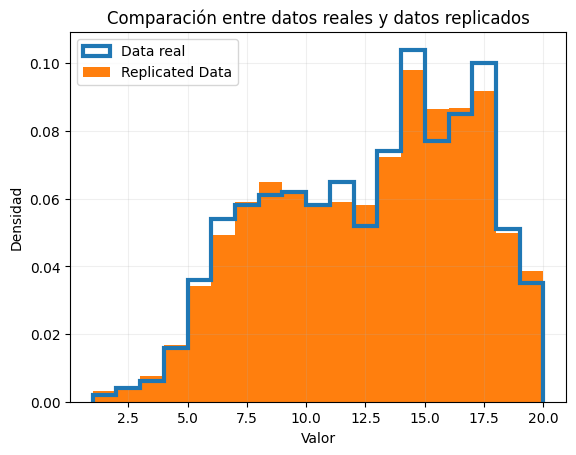

In [10]:
# Extraer los datos replicados
replicated_data_samples = df[[f'replicated_data.{i+1}' for i in range(len(data))]].values


# Plotear comparación
plt.hist(data_scaled, bins=np.linspace(1, m, m), histtype='step',lw=3,density=True, alpha=1, label='Data real')
plt.hist(replicated_data_samples.flatten(), bins=np.linspace(1, m, m), density=True, alpha=1, label='Replicated Data')
plt.legend()
plt.grid(alpha=0.2)
plt.xlabel('Valor')
plt.ylabel('Densidad')
plt.title('Comparación entre datos reales y datos replicados')
plt.show()

Log-probabilidad de los datos reales calculada: -2823.342449706547


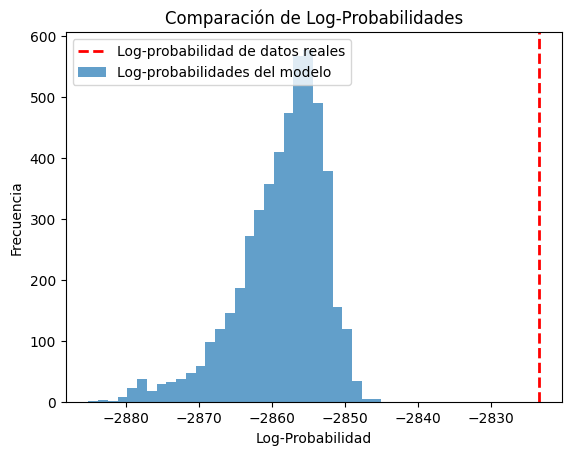

In [11]:
hist, bin_edges = np.histogram(data_scaled, bins=np.linspace(1, m, m), density=True)

# Ajustar los bin_edges para que coincidan con los datos
bin_edges = np.append(bin_edges, bin_edges[-1] + (bin_edges[-1] - bin_edges[-2]))

# Calcular la probabilidad logarítmica de cada dato en data_scaled
log_prob_data = 0
for datum in data_scaled:
    # Encontrar el índice del bin usando searchsorted
    bin_index = np.searchsorted(bin_edges, datum) - 1
    # Asegurarse de que el bin_index esté dentro de los límites correctos
    if bin_index >= 0 and bin_index < m:
        log_prob_data += np.log(hist[bin_index])

# Imprimir el resultado
print(f'Log-probabilidad de los datos reales calculada: {log_prob_data}')

# Visualizar el histograma de las probabilidades log del modelo y de la data
plt.axvline(log_prob_data, color='r', linestyle='dashed', linewidth=2, label='Log-probabilidad de datos reales')
plt.hist(df['lp__'], bins=30, alpha=0.7, label='Log-probabilidades del modelo')
plt.xlabel('Log-Probabilidad')
plt.ylabel('Frecuencia')
plt.title('Comparación de Log-Probabilidades')
plt.legend()
plt.show()


##  Veamos qué pasa cuando no es tan unimodal la curva.

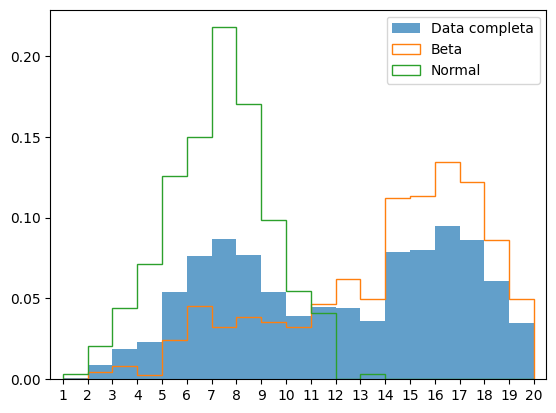

In [12]:
# Parámetros
alpha2 = 7
beta_param2 = 2
mu2 = 0.4
sigma2 = 0.1
p2 = 0.6
seed2 = 3

# Crear datos
data2, labels2 = create_data(alpha2, beta_param2, mu2, sigma2, p2, seed2)

# Definir el número de bins que hay desde 1 a m
m = 20

# Mapear los datos al intervalo de 1 a m
data_scaled2 = ((data2 - data2.min()) / (data2.max() - data2.min()) * (m - 1)).astype(int) + 1

plt.xticks(np.linspace(1,m,m))
plt.xlim(0.5,20.5)
plt.hist(data_scaled2,bins = np.linspace(1,m,m),density=True,alpha=0.7,label='Data completa')
plt.hist(data_scaled2[labels == 'Beta'], bins=np.linspace(1, m, m),histtype='step', density=True, alpha=1, label='Beta')
plt.hist(data_scaled2[labels == 'Normal'], bins=np.linspace(1, m, m),histtype='step', density=True, alpha=1, label='Normal')
plt.legend()

In [13]:
# Construyo y ajusto el modelo de la mixtura
model2 = stan.build(my_mixture, data= {'m': m, 'K': len(data2), 'datos': data_scaled2, 'muj': muj_scaled,'mub': mub_scaled}, random_seed=33)
fit2 = model2.sample(num_chains=5, num_samples=1000)
df2 = fit2.to_frame()

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_83s3p_a7/model_pied4oxe.stan', line 20, column 2: A
    control flow statement depends on parameter(s): theta.
Sampling:   0%
Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   0% (5/10000)
Sampling:   1% (104/10000)
Sampling:   2% (203/10000)
Sampling:   3% (302/10000)
Sampling:   4% (402/10000)
Sampling:   5% (502/10000)
Sampling:   6% (602/10000)
Sampling:   7% (702/10000)
Sampling:   8% (802/10000)
Sampling:   9% (901/10000)
Sampling:  10% (1001/10000)
Sampling:  11% (1101/10000)
Sampling:  12% (1201/10000)
Sampling:  13% (1301/10000)
Sampling:  14% (1401/10000)
Sampling:  15% (1501/10000)
Sampling:  16% (1601/10000)
Sampling:  17% (1701/10000)
Sampling:  18% (1801/10000)
Sampling:  19% (1901/10000)
Sampling:  20% (2001/10000)
Sampling:  21% (2101/10000)
Sampling:  22% (2201/10000)
Sampling:  23% (2301/10000)
Sampling:  24% (2401/10000)
Samplin

p = 0.6531 +- 0.2068


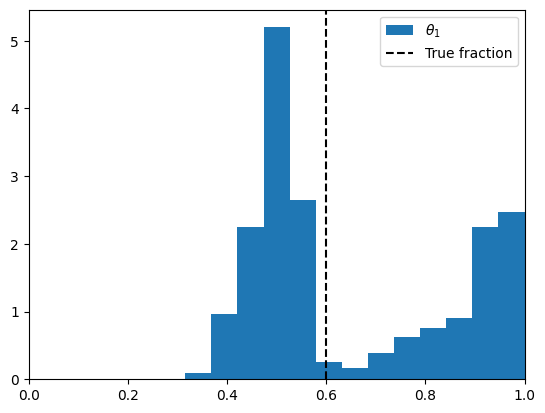

In [14]:
plt.hist(df2['theta.1'],bins=np.linspace(0,1,20),label=r'$\theta_1$',density=True)
#plt.hist(df['theta.2'],bins=30,label=r'$\theta_2$', density = True)
plt.axvline(p2,ls='--',color='black',label='True fraction')
plt.legend()
plt.xlim(0,1)
print('p =',round(np.mean(df2['theta.1']),4),'+-',round(np.std(df2['theta.1']),4))
plt.show()


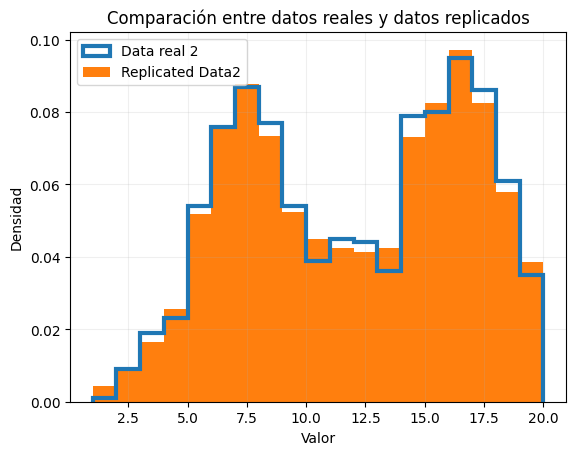

In [15]:
# Extraer los datos replicados
replicated_data_samples2 = df2[[f'replicated_data.{i+1}' for i in range(len(data2))]].values


# Plotear comparación
plt.hist(data_scaled2, bins=np.linspace(1, m, m), histtype='step',lw=3,density=True, alpha=1, label='Data real 2')
plt.hist(replicated_data_samples2.flatten(), bins=np.linspace(1, m, m), density=True, alpha=1, label='Replicated Data2')
plt.legend()
plt.grid(alpha=0.2)
plt.xlabel('Valor')
plt.ylabel('Densidad')
plt.title('Comparación entre datos reales y datos replicados')
plt.show()

Log-probabilidad de los datos reales calculada: -2883.9098264077807


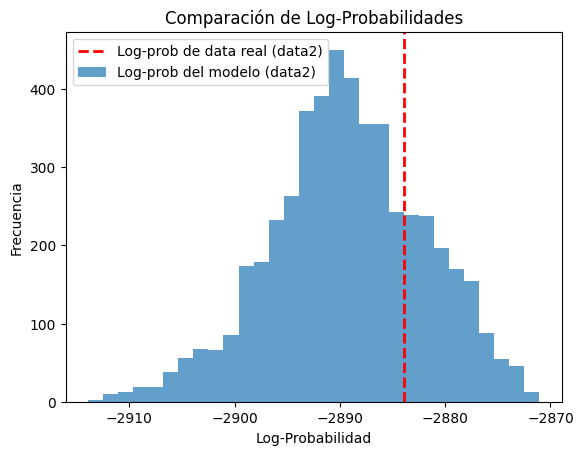

In [16]:
hist2, bin_edges2 = np.histogram(data_scaled2, bins=np.linspace(1, m, m), density=True)

# Ajustar los bin_edges para que coincidan con los datos
bin_edges2 = np.append(bin_edges2, bin_edges2[-1] + (bin_edges2[-1] - bin_edges2[-2]))

# Calcular la probabilidad logarítmica de cada dato en data_scaled
log_prob_data2 = 0
for datum in data_scaled2:
    # Encontrar el índice del bin usando searchsorted
    bin_index2 = np.searchsorted(bin_edges2, datum) - 1
    # Asegurarse de que el bin_index esté dentro de los límites correctos
    if bin_index2 >= 0 and bin_index2 < m:
        log_prob_data2 += np.log(hist2[bin_index2])

# Imprimir el resultado
print(f'Log-probabilidad de los datos reales calculada: {log_prob_data2}')

# Visualizar el histograma de las probabilidades log del modelo y de la data
plt.axvline(log_prob_data2, color='r', linestyle='dashed', linewidth=2, label='Log-prob de data real (data2)')
plt.hist(df2['lp__'], bins=30, alpha=0.7, label='Log-prob del modelo (data2)')
plt.xlabel('Log-Probabilidad')
plt.ylabel('Frecuencia')
plt.title('Comparación de Log-Probabilidades')
plt.legend()
plt.show()


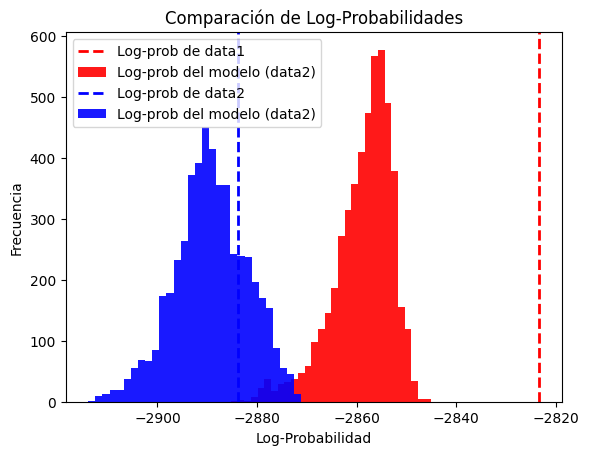

In [17]:
# Visualizar el histograma de las probabilidades log del modelo y de la data

plt.axvline(log_prob_data, color='r', linestyle='dashed', linewidth=2, label='Log-prob de data1')
plt.hist(df['lp__'], bins=30,color='r', alpha=0.9, label='Log-prob del modelo (data2)')


plt.axvline(log_prob_data2, color='b', linestyle='dashed', linewidth=2, label='Log-prob de data2')
plt.hist(df2['lp__'], bins=30, color='b',alpha=0.9, label='Log-prob del modelo (data2)')


plt.xlabel('Log-Probabilidad')
plt.ylabel('Frecuencia')
plt.title('Comparación de Log-Probabilidades')
plt.legend()
plt.show()


Incorporate parallelized calculation (reduce_sum)

In [18]:
my_mixture3 = """
functions {
  real partial_sum(array[] int score_slice,
                   int start, int end,
                   vector yj,
                   vector yb,
                   vector theta) {
    real partial_target = 0;
    vector[2] lp;
    int slice_length = end - start + 1;

    for (k in 1:slice_length) {
      lp[1] = log(yj)[score_slice[k]];
      lp[2] = log(yb)[score_slice[k]];
      partial_target += log_mix(theta, lp);
    }

    return partial_target;
  }
}

data {
  int m;
  int<lower=1> K;  // data points
  array[K] int<lower=1, upper=m> datos;  // b-tagging score for jet#1
}

parameters {
  simplex[2] theta;  // Mixture coefficients as a simplex
  simplex[m] w_j_mode;  // Dirichlet weights
  vector<lower=0>[m-1] a_j;  // Normal parameters
  simplex[m] w_b_mode;  // Dirichlet weights
  vector<lower=0>[m-1] a_b;  // Normal parameters
}

transformed parameters {
  simplex[2] theta_ordered;  // Ordered mixture coefficients

  // Manually order theta
  if (theta[1] < theta[2]) {
    theta_ordered[1] = theta[1];
    theta_ordered[2] = theta[2];
  } else {
    theta_ordered[1] = theta[2];
    theta_ordered[2] = theta[1];
  }

  vector[m] p0_j;  // Approximate distribution
  vector[m-1] sign_j;  // Signs for combination
  vector[m] logp_j;  // Log-probabilities

  sign_j = rep_vector(-1.0, m-1);
  p0_j = rep_vector(0.0, m);

  for (k in 1:m) {
    if (k > 1) {
      for (j in 1:(k-1)) {
        sign_j[j] = 1.0;
      }
    }
    logp_j[1] = 0.0;
    for (j in 2:m) {
      logp_j[j] = logp_j[j-1] + sign_j[j-1] * a_j[j-1];
    }
    p0_j += softmax(logp_j) * w_j_mode[k];
  }

  vector[m] p0_b;  // Approximate distribution
  vector[m-1] sign_b;  // Signs for combination
  vector[m] logp_b;  // Log-probabilities

  sign_b = rep_vector(-1.0, m-1);
  p0_b = rep_vector(0.0, m);

  for (k in 1:m) {
    if (k > 1) {
      for (j in 1:(k-1)) {
        sign_b[j] = 1.0;
      }
    }
    logp_b[1] = 0.0;
    for (j in 2:m) {
      logp_b[j] = logp_b[j-1] + sign_b[j-1] * a_b[j-1];
    }
    p0_b += softmax(logp_b) * w_b_mode[k];
  }
}

model {
  int grainsize = 1;  // Adjust this for optimal parallel performance
  theta ~ dirichlet([1, 1]);
  a_j ~ normal(0, 0.5);
  a_b ~ normal(0, 0.5);
  w_b_mode ~ dirichlet(rep_vector(0.05 / m, m));
  w_j_mode ~ dirichlet(rep_vector(0.05 / m, m));

  target += reduce_sum(partial_sum, datos, grainsize, p0_j, p0_b, theta_ordered);
}

generated quantities {
  array[K] int<lower=1, upper=m> replicated_data;
  for (n in 1:K) {
    real y = bernoulli_rng(theta_ordered[1]);
    if (y == 1) {
      replicated_data[n] = categorical_rng(p0_j);
    } else {
      replicated_data[n] = categorical_rng(p0_b);
    }
  }
}

"""

In [19]:
# Start the timer
start_time_2 = time.time()

# Construyo y ajusto el modelo de la mixtura
#para poner priors,agregar en data  'muj': muj_scaled,'mub': mub_scaled 
model3 = stan.build(my_mixture3, data= {'m': m, 'K': len(data), 'datos': data_scaled}, random_seed=33)
fit3 = model3.sample(num_chains=5, num_samples=1000)
df3 = fit3.to_frame()

# Stop the timer
end_time_2 = time.time()

# Calculate the elapsed time
elapsed_time_2 = end_time_2 - start_time_2

# Print the elapsed time
print(f"Time taken to run the model: {elapsed_time_2:.2f} seconds")

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_i5wqmk2x/model_tauy7qc3.stan', line 97, column 12: The
    variable partial_sum may not have been assigned a value before its use.
Warning in '/tmp/httpstan_i5wqmk2x/model_tauy7qc3.stan', line 40, column 2: A
    control flow statement depends on parameter(s): theta.
Sampling:   0%
Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   0% (5/10000)
Sampling:   1% (104/10000)
Sampling:   2% (203/10000)
Sampling:   3% (302/10000)
Sampling:   4% (402/10000)
Sampling:   5% (501/10000)
Sampling:   6% (601/10000)
Sampling:   7% (701/10000)
Sampling:   8% (801/10000)
Sampling:   9% (901/10000)
Sampling:  10% (1001/10000)
Sampling:  11% (1100/10000)
Sampling:  12% (1200/10000)
Sampling:  13% (1300/10000)
Sampling:  14% (1400/10000)
Sampling:  15% (1500/10000)
Sampling:  16% (1600/10000)
Sampling:  17% (1700/10000)
Sampling:  18% (1800/10000)
Sampling:  19% (19

Time taken to run the model: 81.31 seconds


p = 0.5959 +- 0.2056


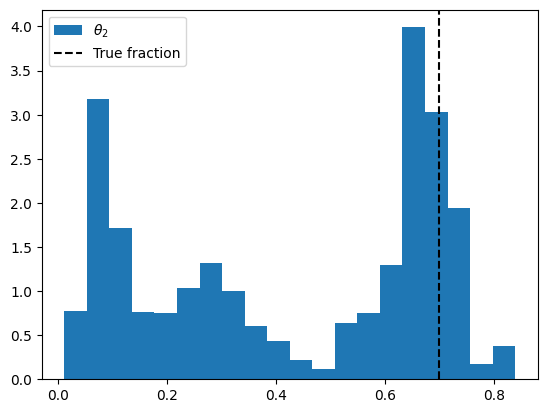

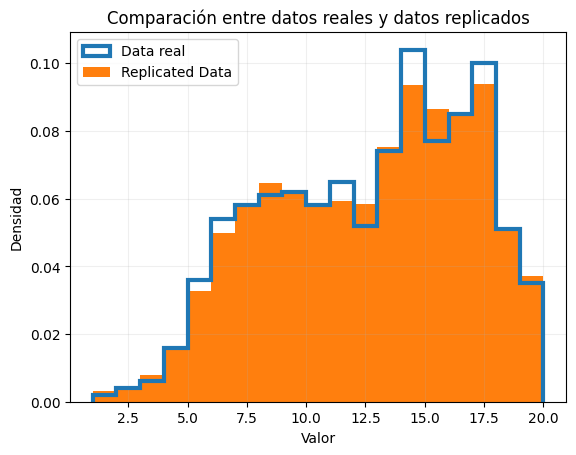

In [20]:
plt.hist(df3['theta.1'],bins=20,label=r'$\theta_2$',density=True)
#plt.hist(df['theta.2'],bins=30,label=r'$\theta_1$', density = True)
plt.axvline(p,ls='--',color='black',label='True fraction')
plt.legend()
print('p =',round(np.mean(df['theta.1']),4),'+-',round(np.std(df['theta.1']),4))
plt.show()


# Extraer los datos replicados
replicated_data_samples3 = df3[[f'replicated_data.{i+1}' for i in range(len(data))]].values


# Plotear comparación
plt.figure()
plt.hist(data_scaled, bins=np.linspace(1, m, m), histtype='step',lw=3,density=True, alpha=1, label='Data real')
plt.hist(replicated_data_samples3.flatten(), bins=np.linspace(1, m, m), density=True, alpha=1, label='Replicated Data')
plt.legend()
plt.grid(alpha=0.2)
plt.xlabel('Valor')
plt.ylabel('Densidad')
plt.title('Comparación entre datos reales y datos replicados')
plt.show()

In [22]:
# Print the elapsed time
print(f"Time taken to run the model without reduce_sum: {elapsed_time:.2f} seconds")
print(f"Time taken to run the model with reduce_sum: {elapsed_time_2:.2f} seconds")

Time taken to run the model without reduce_sum: 118.20 seconds
Time taken to run the model with reduce_sum: 81.31 seconds


In [42]:
elapsed_time/elapsed_time_2 * 100 - 100

45.3719888137673

Aprox un 45.3% más rápido haciendo cálculo paralelizado para el mismo problema.